In [1]:
%load_ext autoreload
%autoreload 2

from enum import Enum
from typing import Optional, List, Callable
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle

# Get project's root directory
BASE_PATH = re.search(r'.+(Team5)', os.getcwd())[0]
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = './data'

## Task 1

In [36]:
"""
# TASK 1: Compute image descriptors (QS1)

Color Histogram:
    - gray level / concatenate color component histograms
    - color space RGB, CieLab, YCbCr, HSV.
    - Compulsory to use 1D histograms!
"""

from src.image_dataset import ImageDataset, ColorSpace
from src.image import ColorSpace, Image

In [61]:
# Load the DataBse and the Query 1
#BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.HSV, interval=1)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.HSV, interval=1)

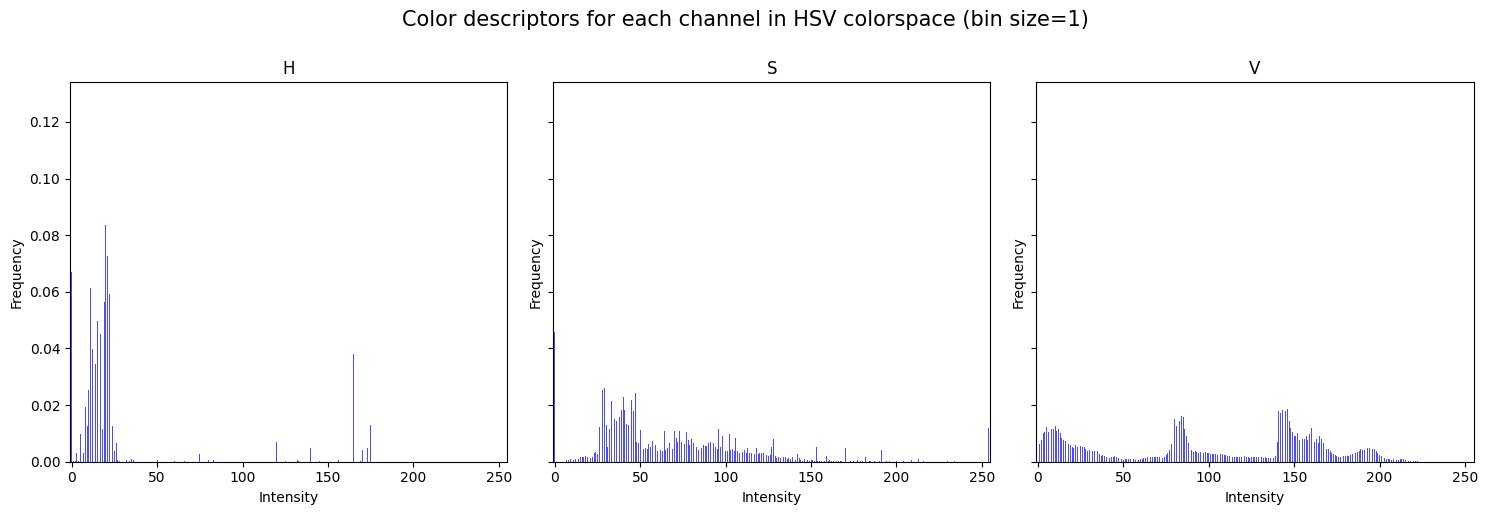

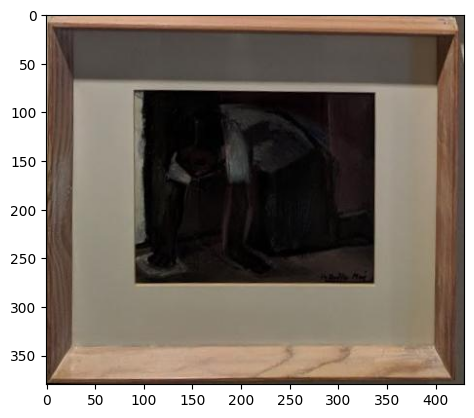

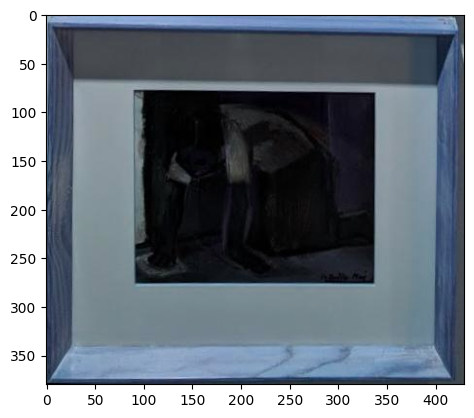

In [62]:
# Plot descriptor (histogram of each color channel) for the first image of the Query dataset. Colorspace: HSV & bin interval size=1
QueryDataset.descriptors[0].plot_histograms()
QueryDataset.descriptors[0].show_original()
QueryDataset.descriptors[0].show()

## Task 2

In [6]:
"""
# TASK 2: Similarity measures

Distance:
    - Euclidean distance
    - L1 distance
    - χ2

Similarity:
    - Histogram intersection (similarity)
    - Hellinger kernel (similarity)
"""

# Implementation of the distances, similarities and evaluation metrics
from src.metrics import *

## Task 3

In [ ]:
"""
# TASK 3: For each image in QSD1, compute similarities to museum images

- Return the top k images (highest score, lowest distance)
- Evaluation with mAP@K (mean Average Precision at K)

Provide mAP@k (k=1, k=5) results for the validation query set (QSD1)
"""

In [ ]:
# Return top k results
k = 5

result = [[] for _ in range(len(QueryDataset.descriptors))]

for image in QueryDataset.descriptors:
    distances_list = []
    for image2 in BDDataset.descriptors:
        distances = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distances) # We can play with min, max, sum ...
        distances_list.append(distance)
    top_k = np.argsort(distances_list)[:k]

    result[image.index] = [BDDataset.descriptors[i].index for i in top_k]

In [7]:
# Load ground truth correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

# Compute mAP@K for k=1 and k=5
mapk(ground_truth, result, k=k)

0.46888888888888897

In [24]:
"""
Let's verify that the distance from the query image to it's correspondence on the DB is lower than a randomly selected image on the DB
"""

image1 = Image(f'{DATA_DIRECTORY}/qsd1_w1/00000.jpg', colorspace=ColorSpace.HSV) # Query (first img of the QSD1)

image1_bbdd = Image(f'{DATA_DIRECTORY}/BBDD/bbdd_00120.jpg', colorspace=ColorSpace.HSV) # BBDD (same img than image1)
rand_image_bbdd = Image(f'{DATA_DIRECTORY}/BBDD/bbdd_00229.jpg', colorspace=ColorSpace.HSV) # BBDD (random img from BBDD)


print(
f'Distance(img1, img1_bbdd): {np.mean(image1.compute_distance(image1_bbdd, type=DistanceType.l1))} \n'
f'Distance(img1, rand_img_bbdd): {np.mean(image1.compute_distance(rand_image_bbdd, type=DistanceType.l1))} \n\n'

'Distance from image1 to it\'s correspondence from BBDD is lower than to a randomly selected image in BBDD. \n'
'Things are working as expected :)'
)

Distance(img1, img1_bbdd): 0.5206865071937165 
Distance(img1, rand_img_bbdd): 0.8166156570173898 

Distance from image1 to it's correspondence from BBDD is lower than to a randomly selected image in BBDD. 
Things are working as expected :)


## Task 3.5: Find top-2 methods

In [ ]:
""" 
Before submiting the results for testing with QST1, let's find the methods that work better.
We will try to optimize mAP@K with the parameters: 
   - Colorspace of the image 
   - bin_size of the hitograms 
   - Metric to compute differences between descriptors (distance or similarity).
   - Handling of the three distances (one for each channel) before computing mAP@K: Mean, min, max, sum...
"""



## Task 4

In [ ]:
""" 
# TASK 4: Submit your results for a “blind” competition in QST1

Format: For each test query in QST1, a list of the K=10 best results:
    - Create a python list of lists, with the image ids (integer numbers)
    - Example with 3 queries and K=2
        Query: [[q1], [q2], [q3]]
        Result: [[7,2], [76, 4], [43, 12]]
    Where 7 corresponds to image 00007.jpg, etc.
"""